This notebook implements the clonotype cluster velocity analysis 

In [13]:
import numpy as np
import pandas as pd

import scanpy as scp
import scvelo as scv
from scipy.stats import zscore

import seaborn as sns
from matplotlib import pyplot as plt

from scipy import sparse
from utils import CELLTYPE_COLOR_DICT

import os

import warnings

%load_ext jupyter_black

import warnings

warnings.simplefilter("ignore", category=UserWarning)

full_data_path = "adata_CD8_Clonotype_TEXH.h5ad"  # "adata_CD8_Clonotype_CytoMem.h5ad"

adata = scp.read(full_data_path)

print(adata.shape)

adata.obs["Clonotype cluster"] = (
    pd.read_csv("clonotype_clusters_spectral_cosine_5_clusters.csv")
    .set_index("new_index")["Clonotype cluster"]
    .astype("category")
)

adata = adata[adata.obs["Clonotype cluster"] != "-1"]
print(adata.shape)

adata.layers["counts"] = adata.raw.X.copy()
adata.layers["counts"] = scp.pp.normalize_total(adata.copy(), inplace=False)["X"]
adata.layers["counts"] = np.log1p(adata.layers["counts"])

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
(943, 2622)
(943, 2622)


In [14]:
adata.var["highly_variable"].sum()

1500

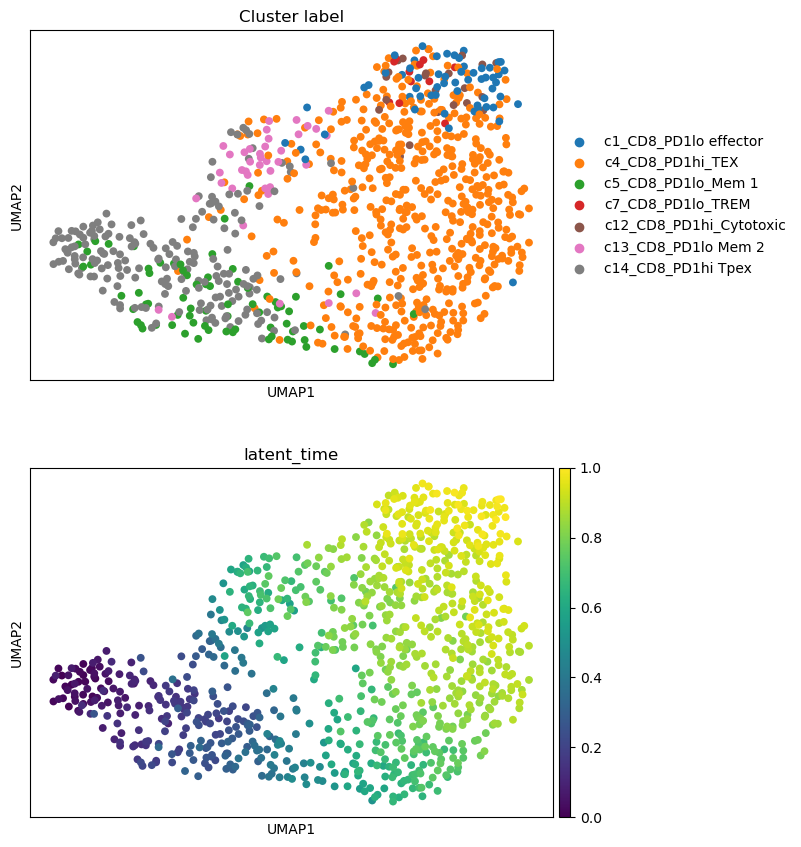

In [15]:
scp.pl.umap(
    adata, color=["Cluster label", "latent_time"], ncols=1, palette=CELLTYPE_COLOR_DICT
)

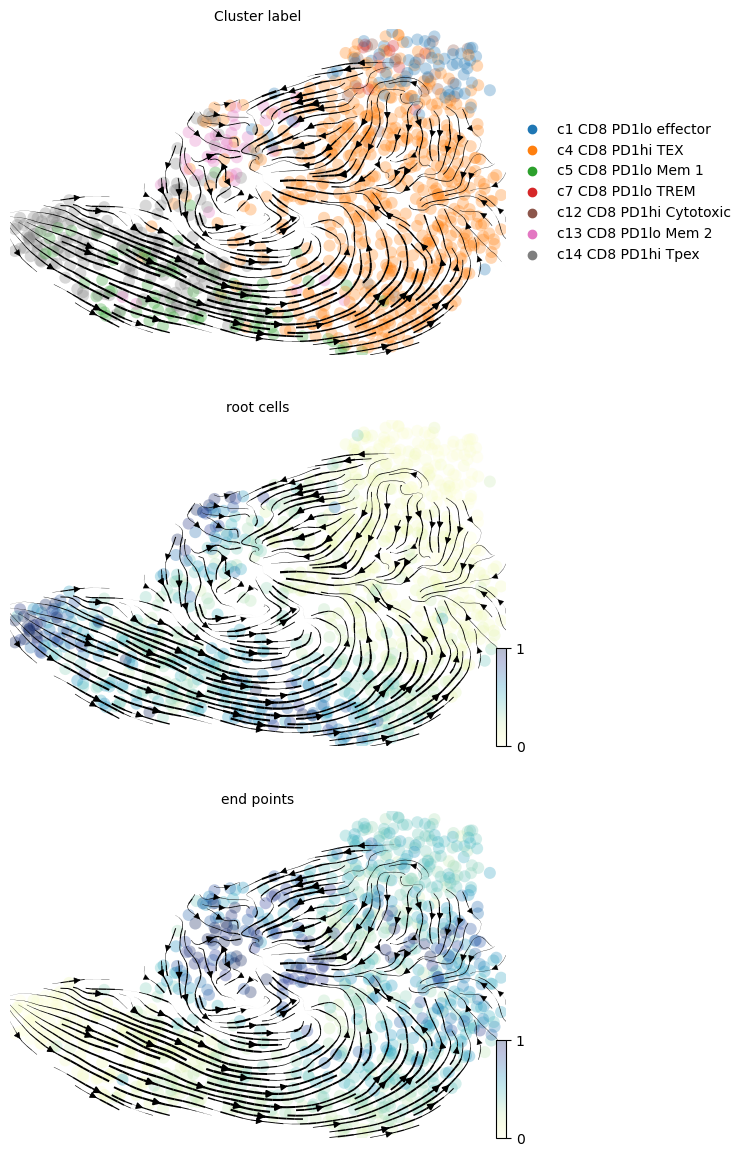

In [16]:
scv.pl.velocity_embedding_stream(
    adata,
    ncols=1,
    size=300,
    color=[
        "Cluster label",
        "root_cells",
        "end_points",
    ],
    color_map="YlGnBu",
    legend_loc="right margin",
    palette=CELLTYPE_COLOR_DICT,
)

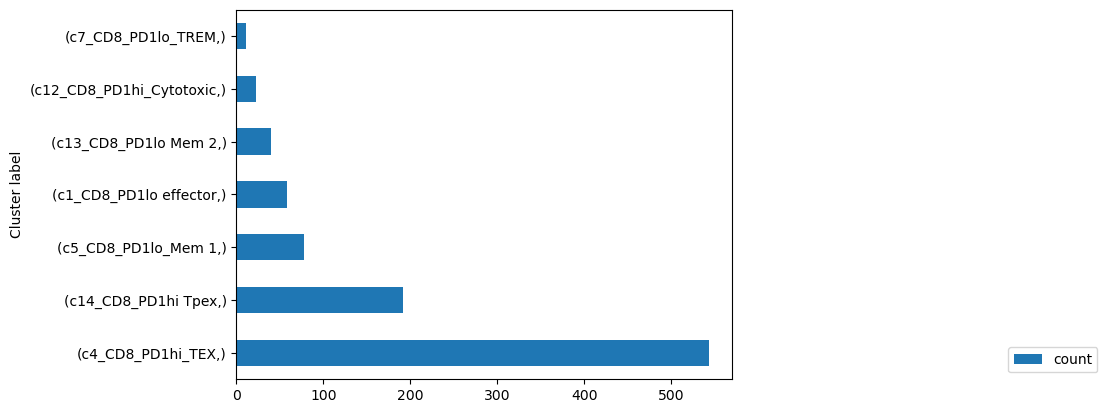

In [365]:
count_df_ = (
    adata.obs.value_counts(["Cluster label"])
    #    .reset_index()
    #   .pivot(index="Clonotype cluster", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=False)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

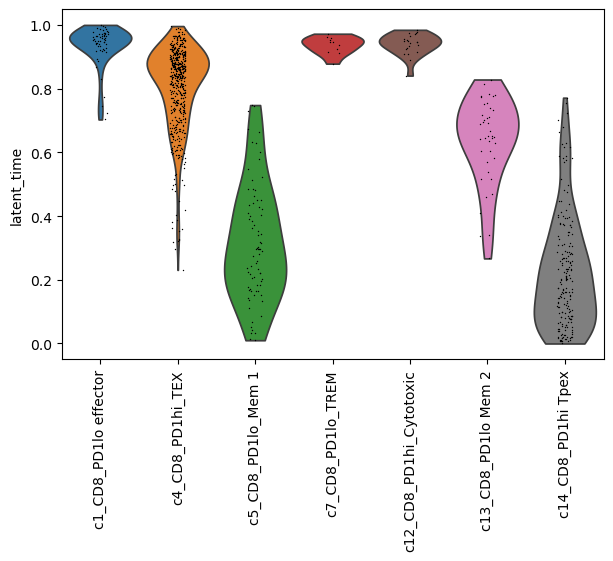

In [366]:
scp.pl.violin(
    adata, keys="latent_time", groupby="Cluster label", rotation=90, color=color_dict
)

In [17]:
breakpoints = [
    0.0,
    0.4,
    0.7,
]  # for cytoMem

breakpoints = [0.0, 0.15, 0.5, 0.8, 0.9]  # for TEXH

In [18]:
# group cells into discrete time intervals
adata.obs["pseudotime cluster"] = 0

ps = 0
for ps in range(len(breakpoints)):

    if ps == (len(breakpoints) - 1):  # account for cell with max pst
        cells_in_step = adata.obs["latent_time"] >= breakpoints[ps]
    else:
        cells_in_step = (adata.obs["latent_time"] >= breakpoints[ps]) & (
            adata.obs["latent_time"] < breakpoints[ps + 1]
        )
    print(cells_in_step.sum())
    adata.obs.loc[cells_in_step, "pseudotime cluster"] = ps

adata.obs["pseudotime cluster"] = pd.Series(
    adata.obs["pseudotime cluster"], dtype="category"
)

91
173
244
226
209


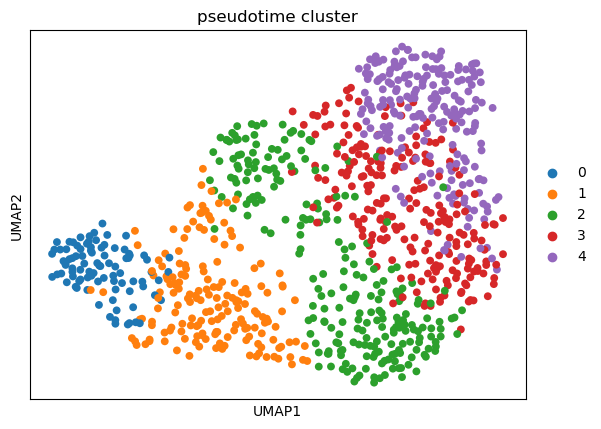

In [19]:
scp.pl.umap(adata, color="pseudotime cluster")

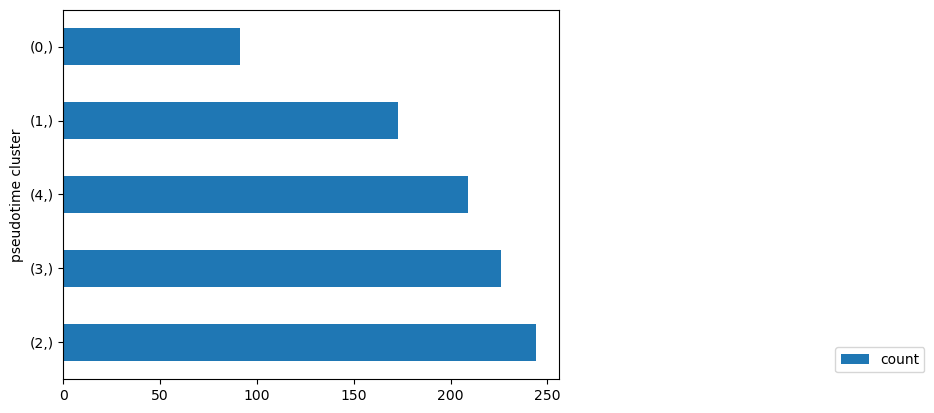

In [20]:
count_df_ = (adata.obs.value_counts(["pseudotime cluster"])).fillna(0)
count_df_.plot.barh(stacked=False)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

In [21]:
PVAL_CUTOFF = 1e-5

# apply wilcoxon DE test to the pseudotime "clusters"

scp.tl.rank_genes_groups(
    adata,
    groupby="pseudotime cluster",
    method="wilcoxon",
    key_added="wilcoxon",
    use_raw=False,
    layer="counts",
)

genes_wilcoxon = adata.uns["wilcoxon"]["names"].tolist()
genes_wilcoxon = np.array(list(sum(genes_wilcoxon, ())))
genes_wilcoxon = [g for g in genes_wilcoxon if g != "nan"]
genes_wilcoxon = list(set(genes_wilcoxon))

de_df = scp.get.rank_genes_groups_df(adata, group=None, key=f"wilcoxon").dropna()

de_df = de_df[de_df["pvals_adj"] < PVAL_CUTOFF]
de_df = de_df[de_df["logfoldchanges"] >= 1]

filtered_genes_wilcoxon = list(de_df["names"].unique())

var_names = {}
for g in de_df["group"].unique():
    var_names[g] = list(de_df[de_df["group"] == g]["names"].values)


print(
    f"Before filtering: {len(genes_wilcoxon)} After filtering: {len(filtered_genes_wilcoxon)}"
)

de_df = de_df.drop_duplicates("names")
gene_dict = {}
for g in de_df["group"].unique():
    gene_dict[g] = de_df[de_df["group"] == g]["names"]

Before filtering: 2622 After filtering: 45


In [22]:
RESOLUTION_HEATMAP = 0.05

mean_expressions = []
times = []

adata_to_plot = adata[:, filtered_genes_wilcoxon]

for ps in range(int(1 / RESOLUTION_HEATMAP)):

    cells_in_step = (adata.obs["latent_time"] >= ps * RESOLUTION_HEATMAP) & (
        adata.obs["latent_time"] < (ps + 1) * RESOLUTION_HEATMAP
    )

    mean_expression = adata_to_plot[cells_in_step].X.T.mean(axis=1)

    mean_expressions.append(mean_expression)

    times.append(ps * RESOLUTION_HEATMAP)


mean_expressions = np.concatenate(mean_expressions, axis=1)
mean_expressions.shape

(45, 20)

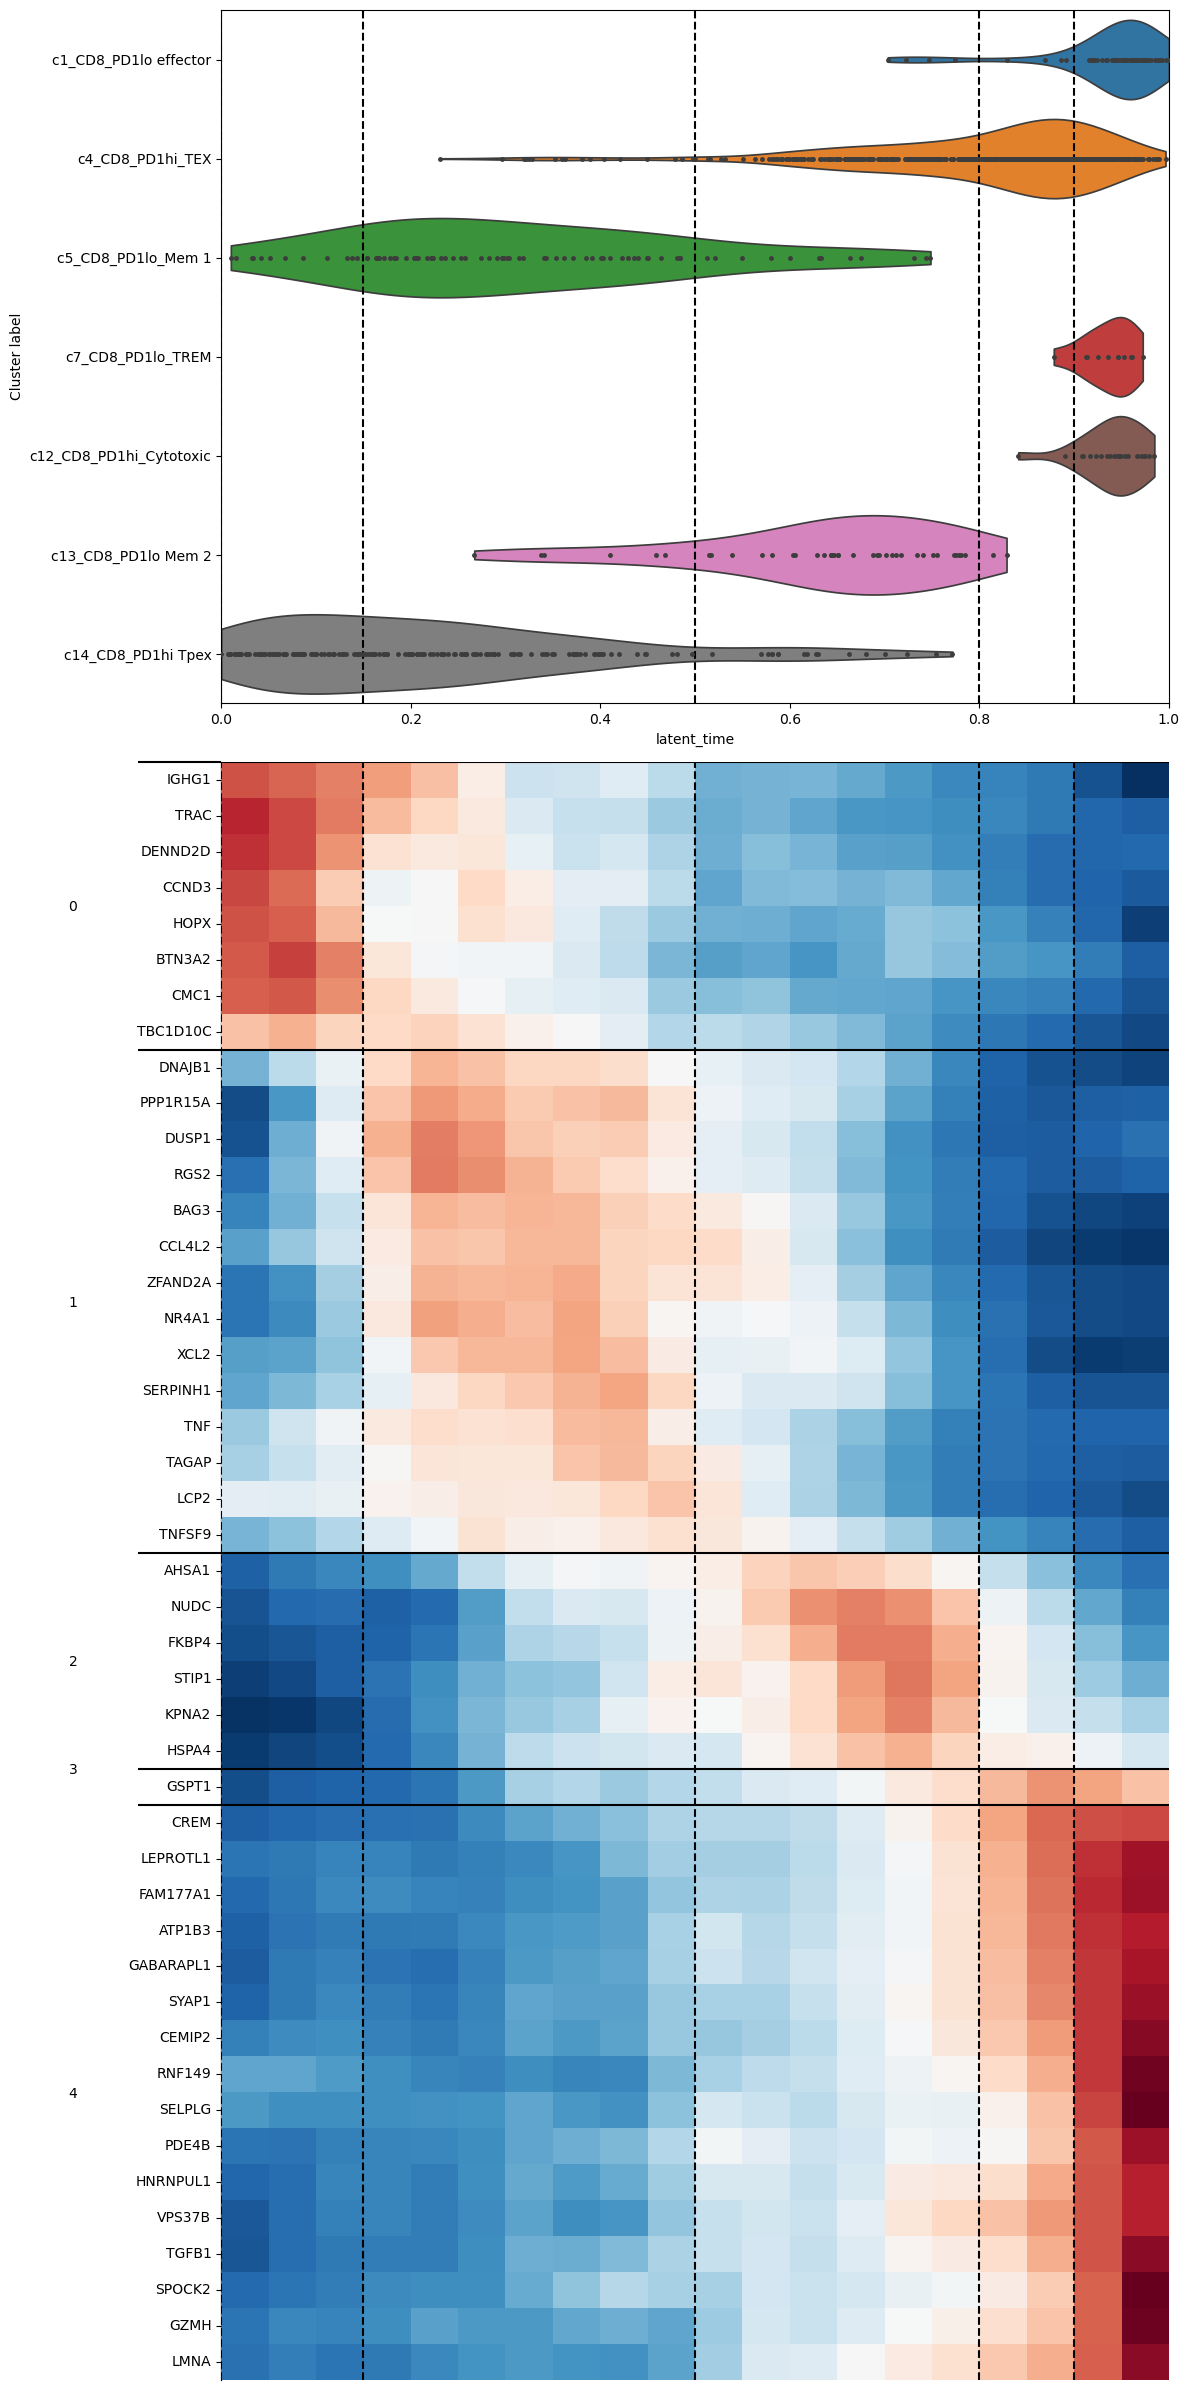

In [25]:
#make a plot  shwoing celltyupe composition and gene expression over pseudotime
RESOLUTION = 0.2

mean_expressions = np.array(mean_expressions)
mean_expressions = zscore(mean_expressions, axis=1)

from scipy.ndimage.filters import gaussian_filter

mean_expressions_smooth = gaussian_filter(mean_expressions, sigma=0.8)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(12, 24),
    height_ratios=[0.3, 0.7],
)


sns.violinplot(
    data=adata.obs,
    x="latent_time",
    y="Cluster label",
    split=False,
    inner="point",
    hue="Cluster label",
    ax=axs[0],
    palette=CELLTYPE_COLOR_DICT,
    cut=0,
)

axs[0].set_xmargin(0)

sns.heatmap(
    mean_expressions_smooth,
    xticklabels=[],
    yticklabels=filtered_genes_wilcoxon,
    # linewidth=0.1,
    linecolor="k",
    cmap="RdBu_r",
    ax=axs[1],
    cbar=False,
)


group_ax = axs[1].secondary_yaxis(location=0)

current = 0
tick_positions = []
sep_positions = []
tick_labels = []
for cluster in gene_dict.keys():
    sep_positions.append(current)
    tick_labels.append(cluster)
    axs[1].axhline(current, color="k", linestyle="-")
    tick_positions.append(current + len(gene_dict[cluster]) // 2)
    current += len(gene_dict[cluster])


group_ax.set_yticks(tick_positions, labels=tick_labels)
group_ax.tick_params("y", length=100, width=0)

# lines between the classes:
sec2 = axs[1].secondary_yaxis(location=0)
sec2.set_yticks(sep_positions, labels=[])
sec2.tick_params("y", length=60, width=1.5)


SPACE = RESOLUTION / RESOLUTION_HEATMAP
current = 1
"""
for ps in range(int(1 / RESOLUTION) - 1):
    position = current * mean_expressions.shape[1] / (1 / RESOLUTION)
    axs[1].axvline(position, color="k", linestyle="--")
    position = current * RESOLUTION
    axs[0].axvline(position, color="k", linestyle="--")

    current += 1
"""


for ps in breakpoints:
    position = ps * mean_expressions.shape[1]
    axs[1].axvline(position, color="k", linestyle="--")
    position = ps
    axs[0].axvline(position, color="k", linestyle="--")

    current += 1

fig.tight_layout()